# Data Preparation

In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
import os

In [2]:
# TODO: Set this appropriately
dropbox_dir = "C:\\Users\\sooraj.raveendra\\Dropbox\\moviemeta\\"

### IMDB Plots

In [3]:
def clean_imdb_df(row):
    '''apply on rows of a dataframe to clean up'''
    #this is because CSV conversion has converted list into string
    row['plots'] = literal_eval(row['plots'])
    try:
        row['year'] = int(row['year'])
        return row
    except:
        row['year'] = np.nan
        return row

movieplots = pd.read_csv(dropbox_dir + 'movieplots.csv')
movieplots = movieplots.apply(clean_imdb_df, axis = 1)

'''
Returns a dataframe containing IMDB plots for a year. If the year parameter is None, returns all data available
'''
def get_imdb_plots(year = None):
    if(year is None):
        return movieplots
    else:
        return movieplots[movieplots.year == year]


### Wikipedia Plots

In [4]:
def read_wiki_df(year):
    return pd.read_table(os.path.join(dropbox_dir, "wikipedia", "wikipedia_plots_%d.csv" % year))

def get_wiki_plots(year = None):
    if(year is None):
        year_range = (2000, 2016)
    else:
        year_range = (year, year + 1)
    
    wikidfs = [read_wiki_df(y) for y in range(*year_range)]
    alldf = pd.concat(wikidfs, ignore_index=True)
    return alldf.drop(alldf.columns[0], axis=1)

# Cleaning of Plot Summaries

In [5]:
import textblob as tb
import nltk
from nltk.corpus import stopwords as sw
from nltk.stem import *
import urllib2
from gensim import models
import slugify as sl
import pickle
import re
import RAKE

In [6]:
def slugify (text):
    """replace special characters with ascii, see https://github.com/un33k/python-slugify"""
    return sl.slugify(text)

In [7]:
def stem(word):
    """stem a word with Porter Stemmer"""
    return PorterStemmer().stem(word)

In [8]:
num = re.compile('\d')
def contains_number(word):
    """check if a word contains a number"""
    return bool(num.search(word))

In [9]:
from urllib import urlretrieve
urlretrieve("https://github.com/nok/rake-text-ruby/blob/master/stoplists/FoxStoplist.txt", "FoxStoplist.txt")
Rake = RAKE.Rake('FoxStoplist.txt')
def keywords(text):
    """extract keywords from text using RAKE algorithm"""
    keywords = Rake.run(text)
    return ' '.join([tup[0] for tup in keywords])

In [10]:
def sentences(text):
    """ tokenize text into sentences using nltk's punkt tokenizer"""
    blob = tb.TextBlob(text.decode('unicode-escape', 'ignore'))
    return blob.sentences

In [11]:
def process(sents, movie_id=None, stop=False, postags=None ):
    """process a list of sentences
    
    Apply stemming, removal of numbers, slugifying to text
    Optionally remove stop words, only include words with a certain POS tag
    
    Args:
        sents (list): sentences
        movie_id (int): movie id of the document that is processed
        stop (bool): remove stopwords
        postags(list): list of POS tags
    Returns:
        tuple containing two represantions of a daocument:
        A list of tagged sentences (e.g. for doc2vec) and a list of words (e.g. for topic detection)
    """
    if stop:
        stopwords = set(sw.words('english'))
    doc_sents  = []
    doc_words  = []
    for sent in sents:
        if postags:
            words = sent.tags
        else:
            words = sent.words
        words_processed = []
        for word in words:
            if postags:
                if word[1] not in postags:
                    continue
                else:
                    word = word[0]
            if stop and word in stopwords:
                    continue
            if contains_number(word):
                    continue
            word = stem(slugify(word))
            if len(word) < 2:
                continue
            words_processed.append(word)
        doc_sents.append(models.doc2vec.LabeledSentence(words_processed,[movie_id]))
        doc_words += words_processed 
    return (doc_sents, doc_words)

# Doc2vec on Movie Plots - IMDB

In [12]:
from gensim import models, corpora
import multiprocessing

In [13]:
def process_d2v_imdb(row):
    movie = row[0]
    plots = ' '.join(row[1])
    return  process(sentences(plots), movie_id=movie, stop=True)[0]

In [29]:
%%time
imdbdf = get_imdb_plots(2015)
plots = imdbdf[['title','plots']].apply(process_d2v_imdb, axis=1)
# filter out very short plot summaries
mask = plots.apply(lambda plot: sum([len(sent.words) for sent in plot]) > 50)
long_plots = plots[mask]

Wall time: 41.5 s


In [30]:
def create_labelled_sent_list(plots):
    sents=[]
    for doc in plots:
        for sent in doc:
            sents.append(sent)
    return sents

In [41]:
cores = multiprocessing.cpu_count()
#d2v = models.Doc2Vec(dm=1, dm_concat=1, size=50, window=10, negative=5, hs=0, min_count=2, workers=cores)
d2v = models.Doc2Vec(dbow_words=1, size=50)
#Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)
#Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
all_sent = create_labelled_sent_list(plots)
long_plots_sent = create_labelled_sent_list(long_plots)
d2v.build_vocab(all_sent)
d2v.train(long_plots_sent)

521620

In [42]:

imdb_titles = list(set([s.tags[0] for s in long_plots_sent]))
imdb_vectors = [d2v.docvecs[t] for t in imdb_titles]

## Visualize clusters

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA

In [45]:
def apply_mds(vectors):
    mds = MDS(n_components=2, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = mds[:, 0]
    df['y'] = mds[:, 1]
    return df

def apply_tsne(vectors, rate=1000):
    tsne = TSNE(learning_rate=rate, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = tsne[:, 0]
    df['y'] = tsne[:, 1]
    return df

def apply_pca(vectors):
    pca = PCA().fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = pca[:, 0]
    df['y'] = pca[:, 1]
    return df

def apply_isomap(vectors, neighbours=10):
    map_2d = Isomap(neighbours, 2, eigen_solver='auto').fit_transform(vectors)    
    df = pd.DataFrame(map_2d, columns=['x', 'y'])
    return df

Wall time: 120 ms


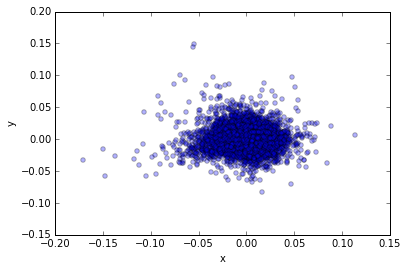

In [48]:
%%time
imdb_d2v_pca = apply_pca(imdb_vectors)
imdb_d2v_pca.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 6min 43s


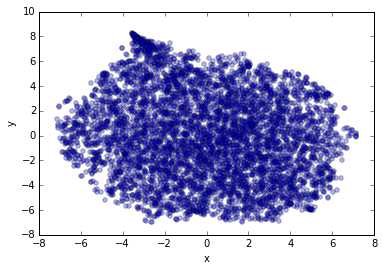

In [49]:
%%time
imdb_d2v_tsne = apply_tsne(imdb_vectors)
imdb_d2v_tsne.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 3min 12s


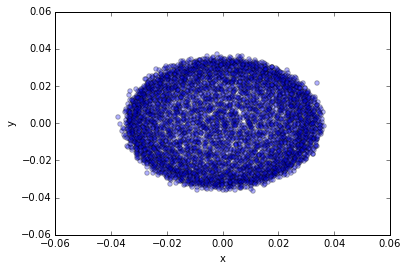

In [65]:
%%time
imdb_d2v_mds = apply_mds(imdb_vectors)
imdb_d2v_mds.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 17 s


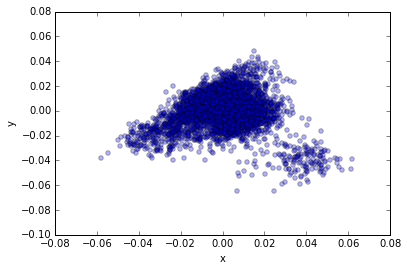

In [64]:
%%time
imdb_d2v_isomap = apply_isomap(imdb_vectors)
imdb_d2v_isomap.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

# Doc2vec on Movie Plots - Wikipedia

In [98]:
from matplotlib import pyplot
from matplotlib  import cm
import matplotlib.colors as mpcol

def plot_2d_scatter(df, labels, categories, title):
    if(categories is not None):
        df['cat'] = categories
        groups = df.groupby('cat')
        fig, ax = pyplot.subplots(figsize=(10, 10))
        #plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
        colors = pd.tools.plotting._get_standard_colors(len(groups), colormap=cm.jet)
        ax.set_color_cycle(colors)
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
        ax.legend(numpoints=1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.figure(figsize=(10, 10))
        a = df.plot(kind='scatter', x='x', y='y', marker='o')
        a.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    if(labels != None):
        for label, x, y in zip(labels, df.x, df.y):
            pyplot.annotate(label, xy=(x, y))
    
    plt.title(title)
    plt.show()

In [99]:
def process_d2v_wiki(row):
    return  process(sentences(row.wiki_plot), movie_id=row.title, stop=True)[0]

wiki_df = get_wiki_plots(2014)
# discard empty plots
wiki_df = wiki_df[~ wiki_df.wiki_plot.isnull()]
plots = wiki_df[['title','wiki_plot']].apply(process_d2v_wiki, axis=1)


In [100]:
def create_labelled_sent_list(plots):
    sents=[]
    for doc in plots:
        for sent in doc:
            sents.append(sent)
    return sents

all_sent = create_labelled_sent_list(plots)

In [101]:
%%time
cores = multiprocessing.cpu_count()
#d2v_wiki = models.Doc2Vec(dm=1, dm_concat=1, size=50, window=10, negative=5, hs=0, min_count=2, workers=cores)
d2v_wiki = models.Doc2Vec(dbow_words=1, size=50)
#Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)
#Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
d2v_wiki.build_vocab(all_sent)
d2v_wiki.train(all_sent)

Wall time: 1.09 s


In [111]:
wiki_titles = list(set([s.tags[0] for s in all_sent]))
wiki_vectors = [d2v_wiki.docvecs[t] for t in wiki_titles]

countries = ['US', 'Germany', 'Korea', 'Japan', 'China', 'China, Hong Kong', 'India', 'United Kingdom', 'United States', 'South Korea']
country_vector = [c if c in countries else 'Other' for c in wiki_df.countries]
## Since there are missing indices, make this a series so that it matches with the data frame
country_vector = pd.Series(country_vector, index=wiki_df.index)

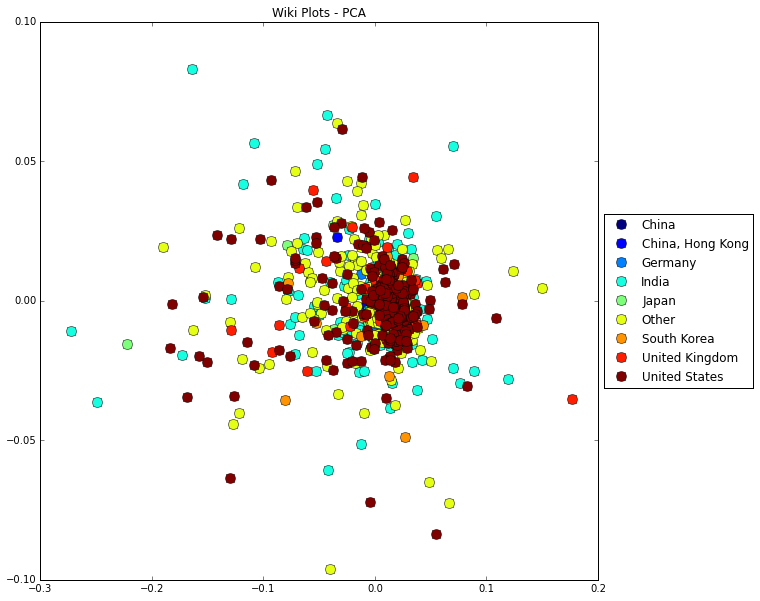

Wall time: 235 ms


In [112]:
%%time
wiki_d2v_pca = apply_pca(wiki_vectors)
plot_2d_scatter(wiki_d2v_pca, None, country_vector, "Wiki Plots - PCA")

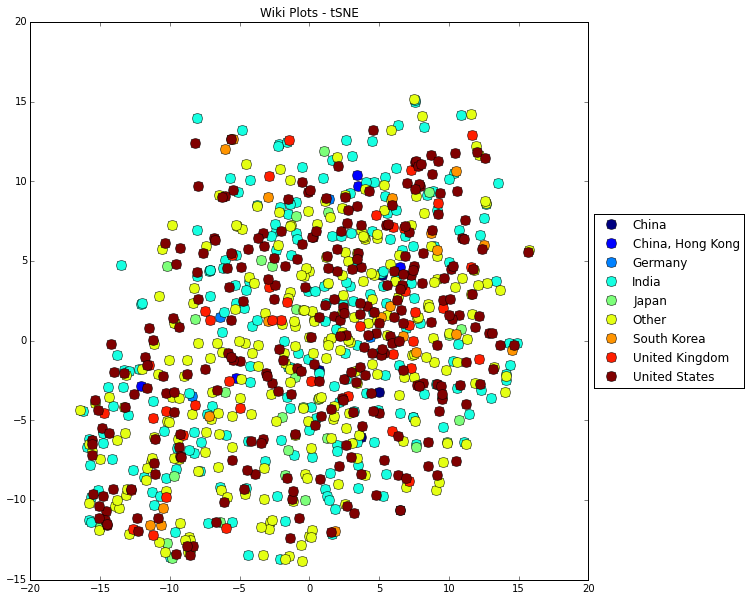

Wall time: 10.1 s


In [113]:
%%time
wiki_d2v_tsne = apply_tsne(wiki_vectors)
plot_2d_scatter(wiki_d2v_tsne, None, country_vector, "Wiki Plots - tSNE")

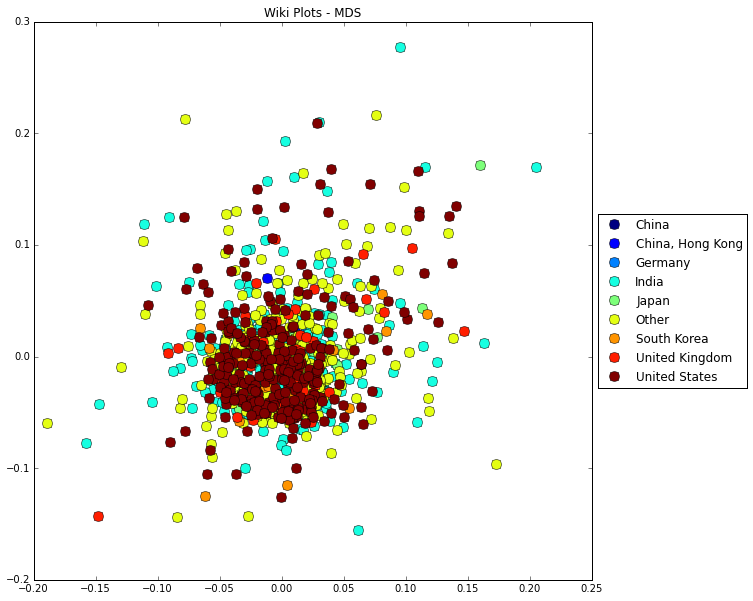

Wall time: 58 s


In [114]:
%%time
wiki_d2v_mds = apply_mds(wiki_vectors)
plot_2d_scatter(wiki_d2v_mds, None, country_vector, "Wiki Plots - MDS")